In [1]:
import numpy as np
import os
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
import coop_post_processing as cpp
import matplotlib as mpl
from PIL import Image
from scipy import ndimage
import scipy as sp
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import stats as st
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
#matplotlib settings
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'
# mpl.rc('text', usetex=True)
# mpl.rcParams['figure.figsize'] = [5.0, 4.0]
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['font.size']=14

In [2]:
def get_cov_unoriented(covmat):
    eigvals, eigvects = np.linalg.eig(covmat)
    amps = 2.3*np.sqrt(eigvals)
    return(amps)

def chisq(data_vector, theory_vector, covmat):
    chisq = np.matmul(np.matmul((data_vector-theory_vector).T,np.linalg.inv(covmat)),(data_vector-theory_vector))
    return(chisq)

def chisq_simpler(data_vector, theory_vector, covmat):
    chisq = np.sum((data_vector-theory_vector)**2/np.diag(covmat))
    return chisq

def integrate(profile, r, upper_bound, errors=None):
    reimann_sum = 0
    error_sum   = 0
    delta_r = r[1]-r[0]
    ub_idx = (np.abs(r - upper_bound)).argmin()
    for i in range(ub_idx+1):    
        reimann_sum += r[i]*profile[i]*delta_r
        if errors is not None:
            error_sum += (delta_r*r[i]*errors[i])**2
    return(reimann_sum*np.pi, np.sqrt(error_sum)*np.pi)


def snr_simple(data_vector, null_vector, covmat, chisq_data):
    size = 1*10**6
    exceeds = np.zeros(size)
    sim = np.random.multivariate_normal(null_vector, covmat, size=size)
    for i in range(size):
        chisq_null = chisq_simpler(sim[i], null_vector, covmat)
        if chisq_null > chisq_data:
            exceeds[i] = 1
    print("Number exceeding: ", len(np.where(exceeds == 1)[0]))
    pte = len(np.where(exceeds == 1)[0])/(float(size))
    snr = np.sqrt(2.) * sp.special.erfinv(1.-pte)
    return(pte,snr)

In [3]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
actpath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
desunoriented =  "/mnt/raid-cita/mlokken/data/unorienteds/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_unoriented_hpx_4096.fits"

0.20003758488609932 redshift 0.35676599555664823 redshift
0.35676599555664823 redshift 0.529248153677234 redshift
0.529248153677234 redshift 0.7217486066173794 redshift
0.7217486066173794 redshift 0.9396327748501414 redshift


In [4]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24

In [68]:
# check the full stack

null_chi2_full = np.zeros((5,1))
null_pte_full = np.zeros((5,1))
cl_dbin = [893, 3193]

cl_dlow, cl_dhi = cl_dbin[0], cl_dbin[1]
dlow   = cl_dlow-50
dhi    = cl_dhi+50
# mapstr = 'ilc_SZ_yy_4096_hpx'

# mapstr = 'kappa_bin4'
c=0
mapstr = f'DES_maglim_z_{zbins[c]}'

randrotfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_randrot_cc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, nreg)
unoriented, (zlow,zhi)   = cpp.retrieve_stack_info(None, None, None, cl_dbin, fullfile=randrotfile, remove_r30=True)
mlen = len(unoriented.avg_profiles)
for m in range(mlen):
    null_vector = np.zeros(len(unoriented.avg_profiles_binned[m]))
    chi2 = chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])
    # print("Chi-squared of unoriented stack w.r.t. zero", st.chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])/(len(unoriented.avg_profiles[m])-1))
    # pte, snr = st.snr_from_pte(unoriented.avg_profiles_binned[m][1:], null_vector[1:], unoriented.covmat_binned[m][1:,1:], chisq_data=None)
    null_chi2_full[m,c] = chi2
    dof = len(unoriented.avg_profiles_binned[m])
    pval = stats.chi2.sf(chi2, dof)
    null_pte_full[m,c] = pval

    plt.errorbar(unoriented.r_binned, unoriented.avg_profiles_binned[m], yerr=unoriented.errors_binned[m], fmt='o', linestyle='--', label='stacked unoriented, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.title("m={:d}".format(m))
    plt.show()
    plt.clf()
    
print(len(unoriented.img_splits), unoriented.Nsamples)
plt.imshow(unoriented.avg_img, origin='lower', vmin=np.mean(unoriented.avg_img)-2*np.std(unoriented.avg_img), vmax=np.mean(unoriented.avg_img)+2*np.std(unoriented.avg_img))
plt.colorbar()
plt.show()
plt.clf()

print(np.sum(unoriented.Npks_splits))
# profs_dbin.append(unoriented.avg_profiles_binned[m])
# errors_dbin.append(errs.errors_binned[m])

retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_3193Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_3193Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl'

In [16]:
def get_chi2_pte_null(mapstr):
    null_chi2 = np.zeros((5,len(dbins)))
    null_pte = np.zeros((5,len(dbins)))
    for c, cl_dbin in enumerate(dbins):
        cl_dlow, cl_dhi = cl_dbin[0], cl_dbin[1]
        if 'maglim' in mapstr:
            mapstr_extra = f'{zbins[c]}'
        else:
            mapstr_extra = ''
        randrotfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_randrot_cc_{:d}reg_m0to5_profiles.pkl".format(mapstr, mapstr_extra, cl_dlow, cl_dhi, pt_selection_str, nreg)
        unoriented, (zlow,zhi)   = cpp.retrieve_stack_info(None, None, None, cl_dbin, fullfile=randrotfile, remove_r30=True)
        mlen = len(unoriented.avg_profiles)
        for m in range(mlen):
            null_vector = np.zeros(len(unoriented.avg_profiles_binned[m]))
            chi2 = chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])
            # print("Chi-squared of unoriented stack w.r.t. zero", st.chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])/(len(unoriented.avg_profiles[m])-1))
            # pte, snr = st.snr_from_pte(unoriented.avg_profiles_binned[m][1:], null_vector[1:], unoriented.covmat_binned[m][1:,1:], chisq_data=None)
            null_chi2[m,c] = chi2
            dof = len(unoriented.avg_profiles_binned[m])
            pval = stats.chi2.sf(chi2, dof)
            null_pte[m,c] = pval
            print("SNR", np.sqrt(chi2))
            plt.errorbar(unoriented.r_binned, unoriented.avg_profiles_binned[m], yerr=unoriented.errors_binned[m], fmt='o', linestyle='--', label='stacked unoriented, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
            plt.legend()
            plt.title("m={:d}, {:s}".format(m, mapstr))
            plt.show()
            plt.clf()
            
        print(len(unoriented.img_splits), unoriented.Nsamples)
        plt.imshow(unoriented.avg_img, origin='lower', vmin=np.mean(unoriented.avg_img)-2*np.std(unoriented.avg_img), vmax=np.mean(unoriented.avg_img)+2*np.std(unoriented.avg_img))
        plt.colorbar()
        plt.show()
        plt.clf()
        
        print(np.sum(unoriented.Npks_splits))
    return null_chi2, null_pte
    # profs_dbin.append(unoriented.avg_profiles_binned[m])
    # errors_dbin.append(errs.errors_binned[m])

retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt20_0pt36_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 17.223296735308455


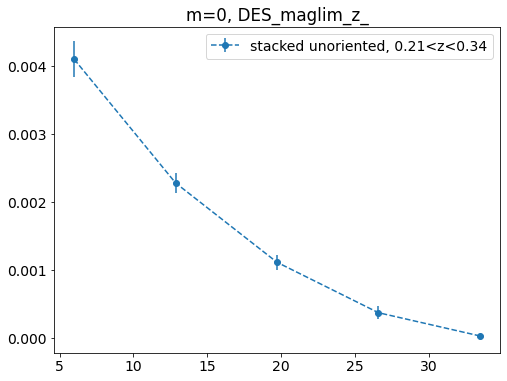

SNR 3.936433832715488


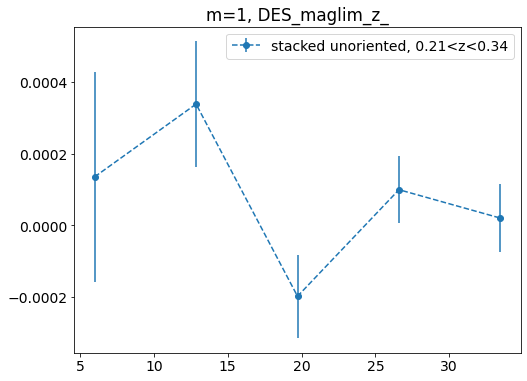

SNR 2.6549707899776935


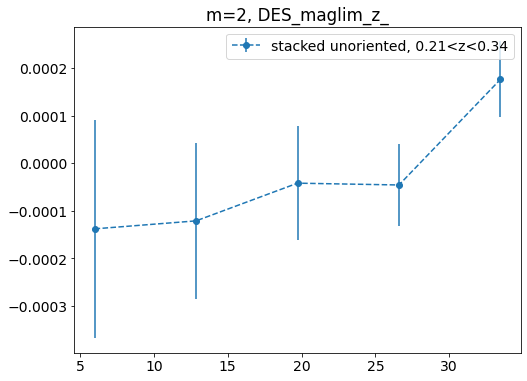

SNR 4.094157249856908


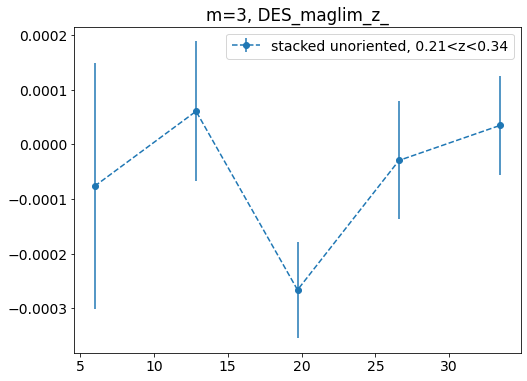

SNR 1.4965953834932426


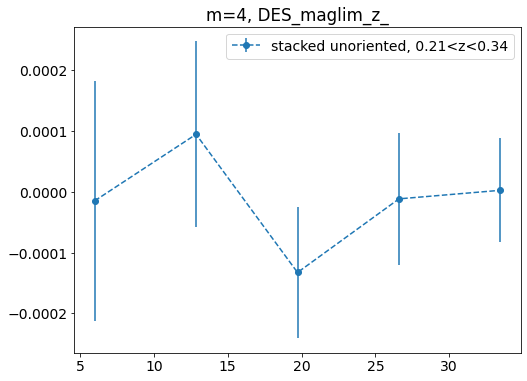

23 23


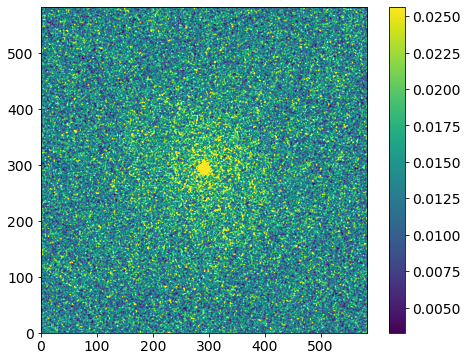

517
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt36_0pt53_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 19.500458409010413


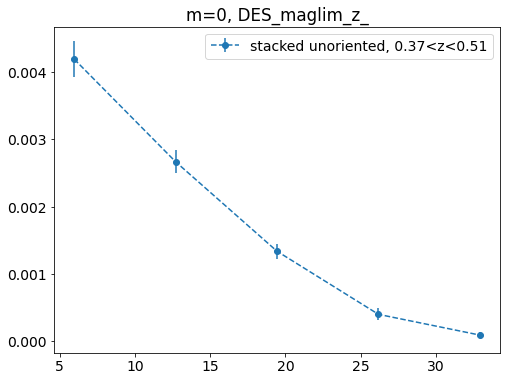

SNR 2.017384904831946


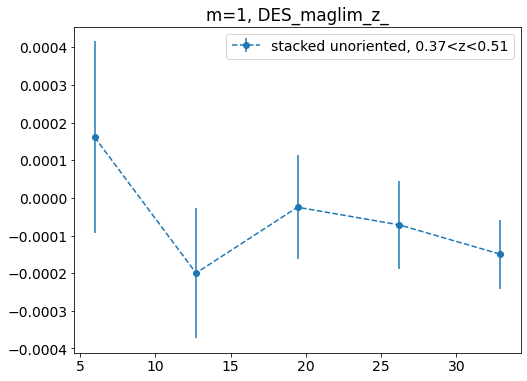

SNR 1.5941514673870112


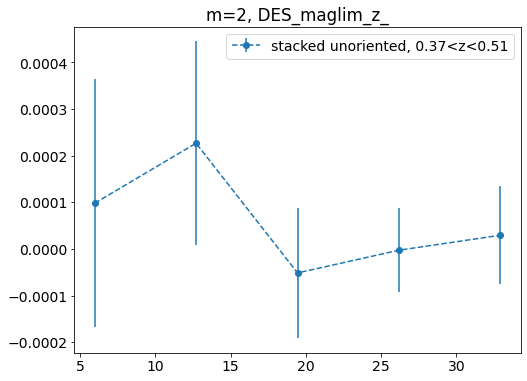

SNR 2.1343318021664928


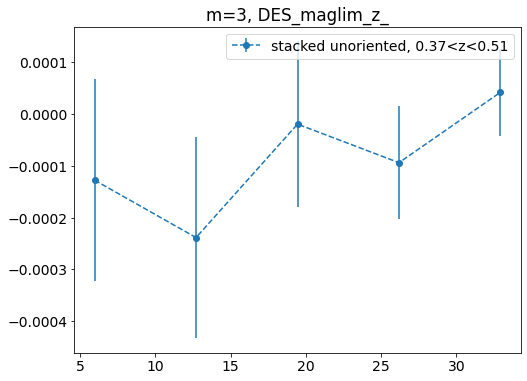

SNR 1.285962427899759


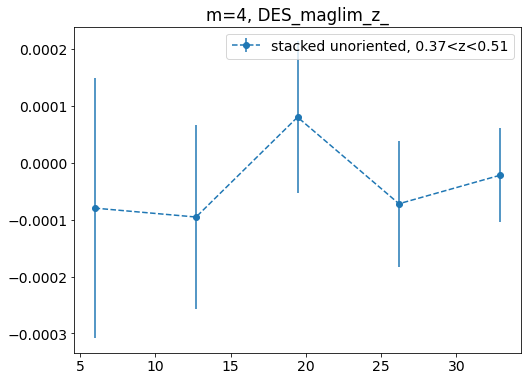

24 24


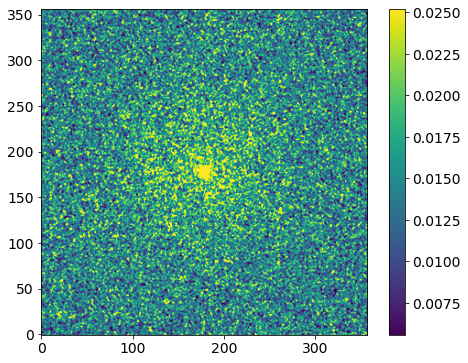

782
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt53_0pt72_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 22.865313740374614


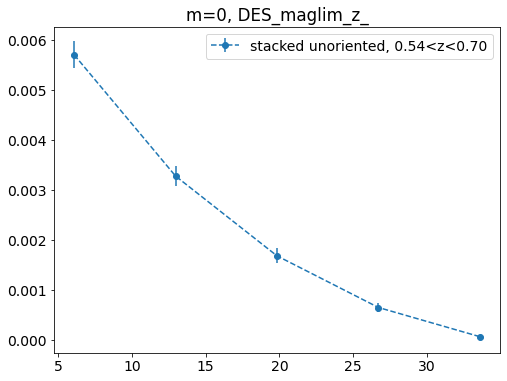

SNR 4.090700141516067


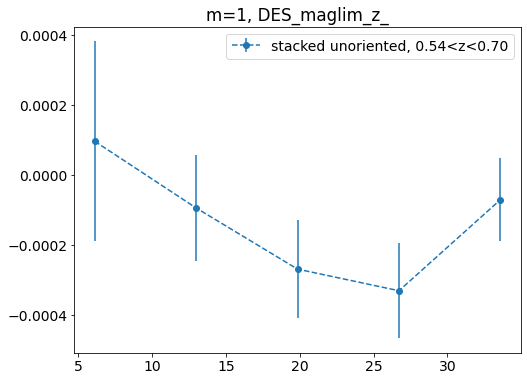

SNR 1.6371648941551946


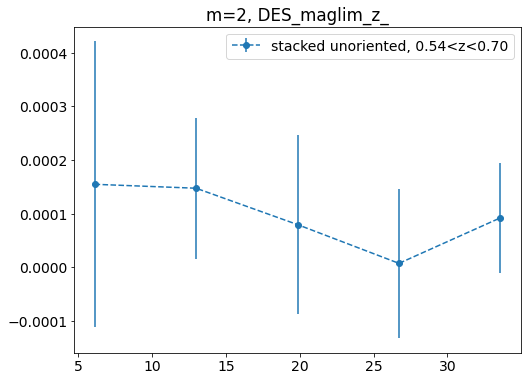

SNR 2.63095986315932


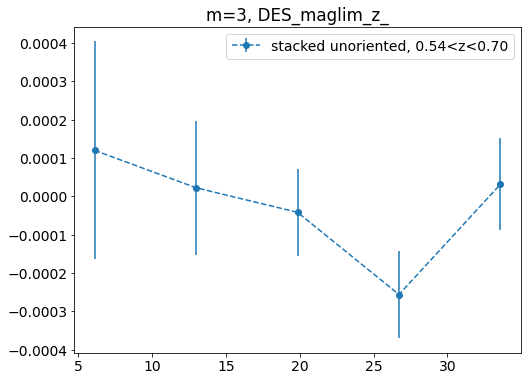

SNR 1.7395961014009476


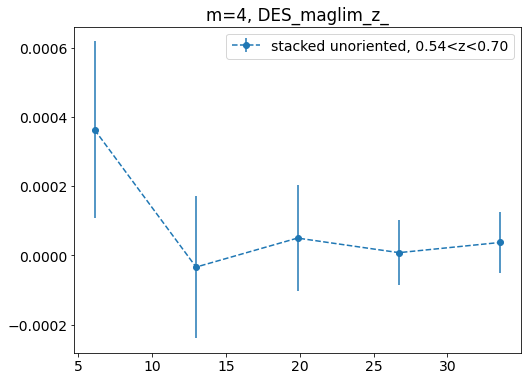

24 24


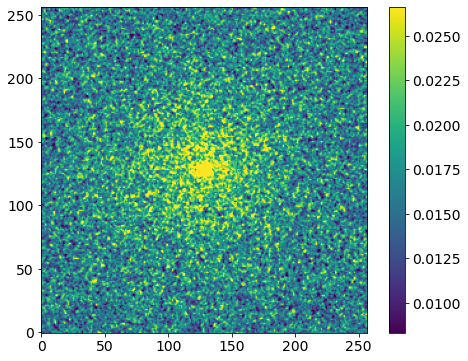

1279
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 30.344028692420014


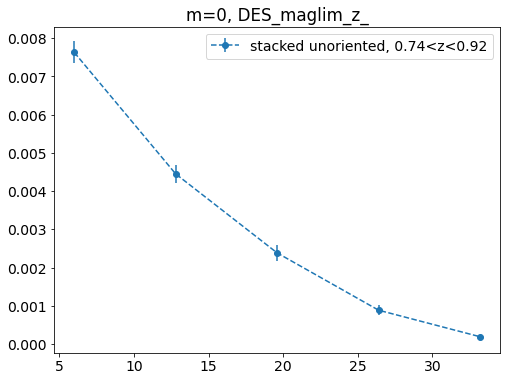

SNR 2.1121714541190793


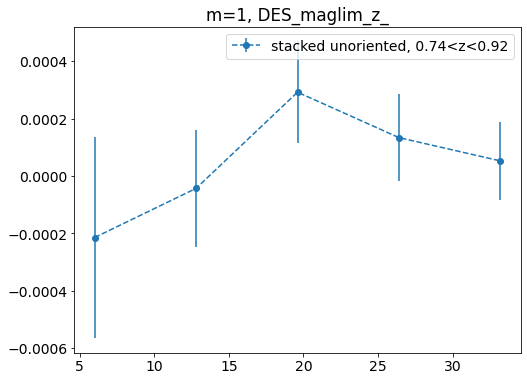

SNR 1.4766556018136945


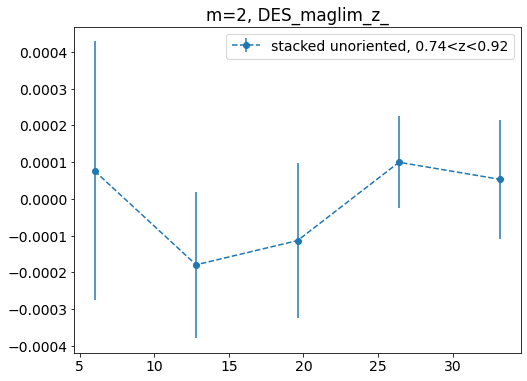

SNR 0.8128686776103634


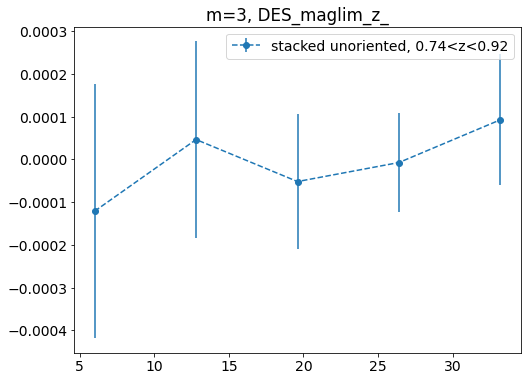

SNR 2.270559511669929


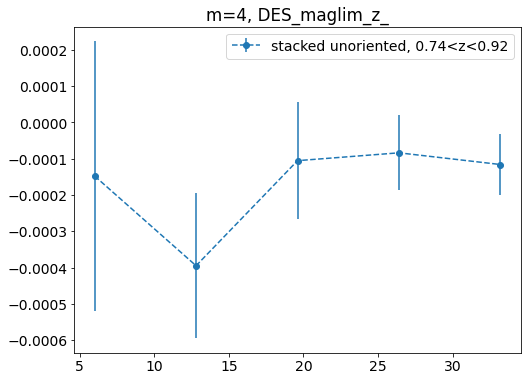

24 24


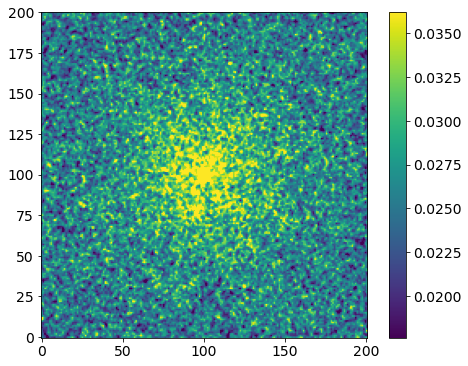

2070
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_yy_4096_hpx_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 4.279452577298106


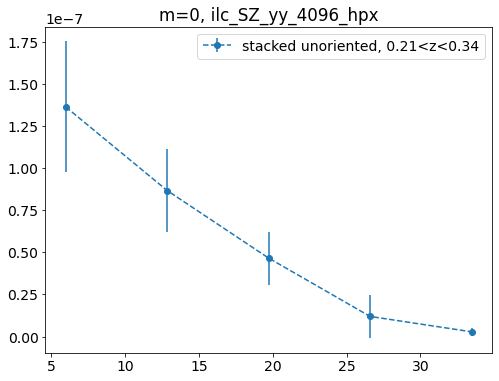

SNR 1.3619007609568066


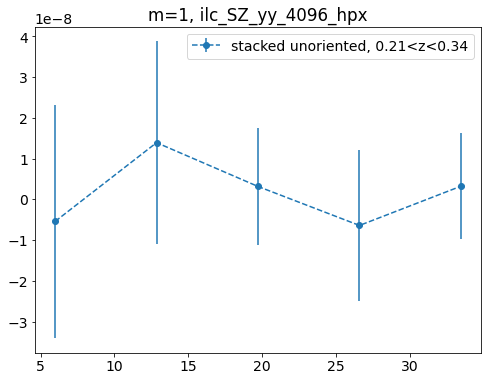

SNR 3.044036321563497


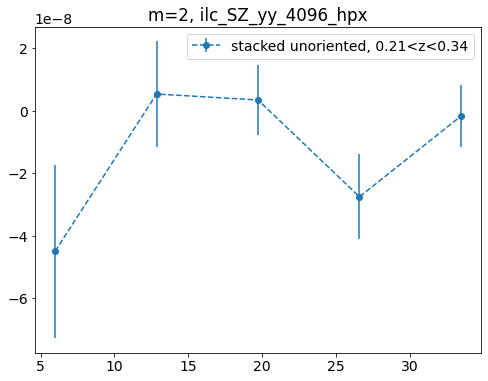

SNR 2.212938037706337


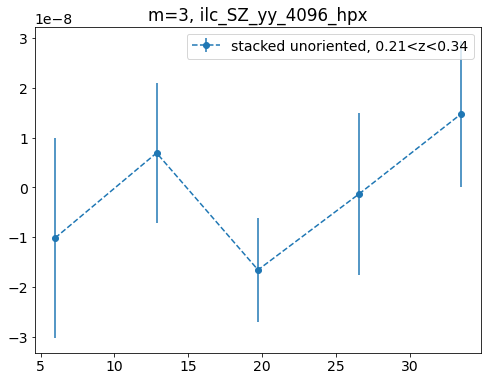

SNR 2.762069825788767


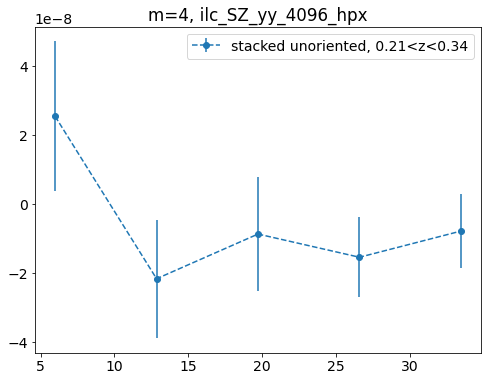

23 23


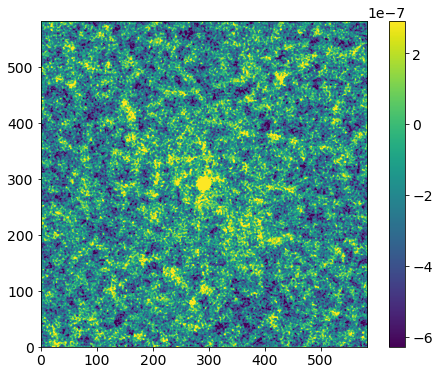

517
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_yy_4096_hpx_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 8.22197341062846


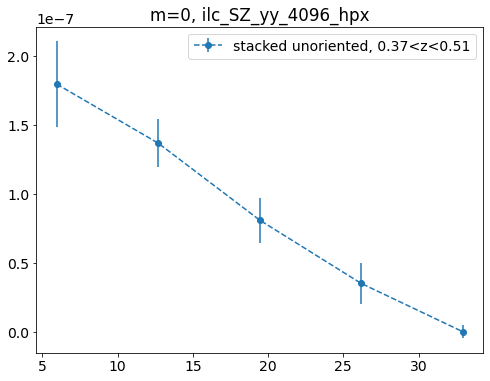

SNR 1.280490672705838


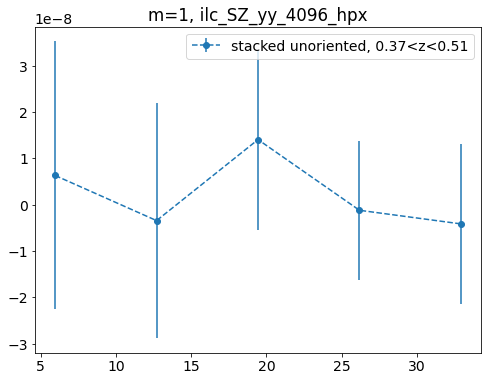

SNR 1.4774059417769994


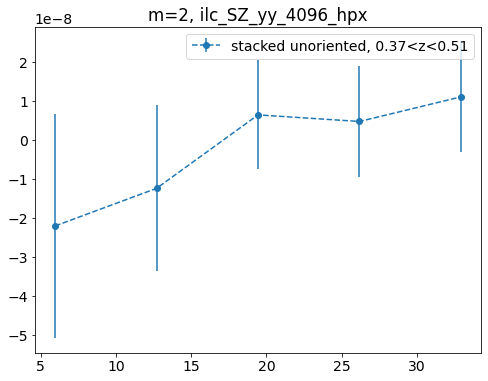

SNR 1.6167433188919558


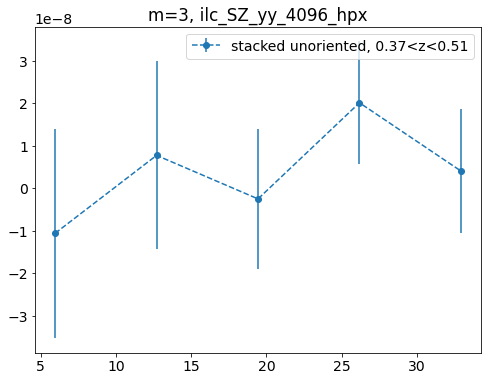

SNR 2.8163227109083393


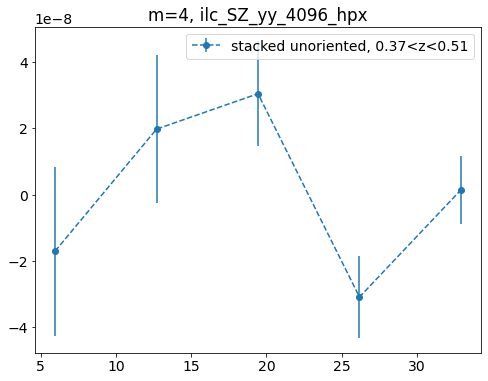

24 24


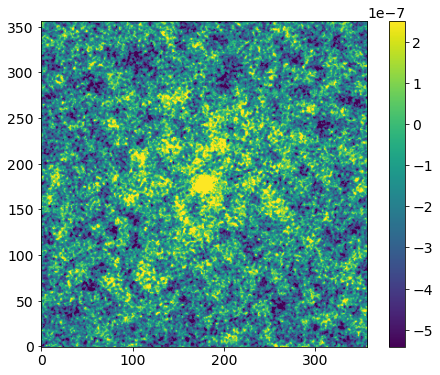

782
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_yy_4096_hpx_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 7.137575002692414


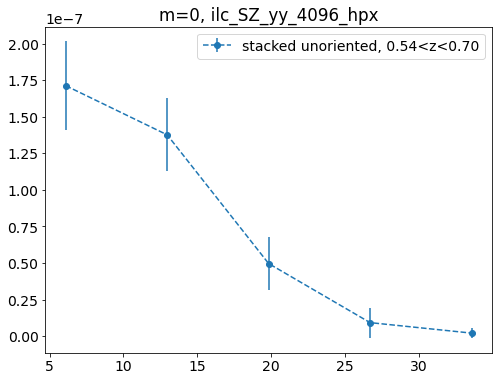

SNR 2.6353319027716764


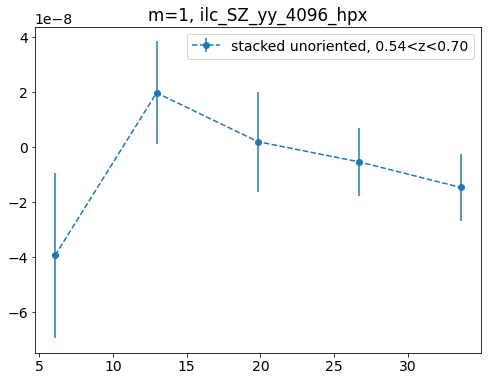

SNR 2.213204397553584


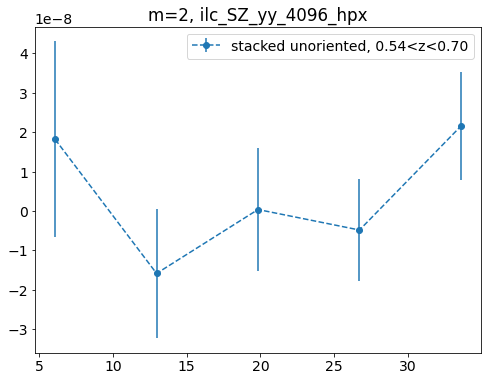

SNR 1.0924231733706091


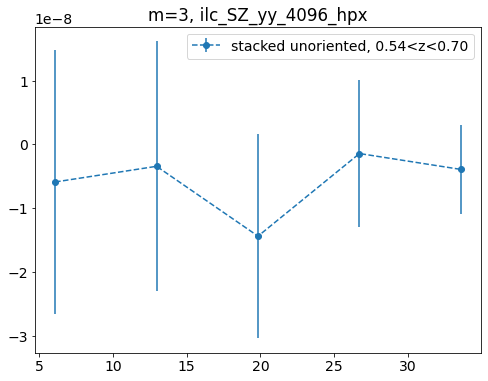

SNR 1.965093327624575


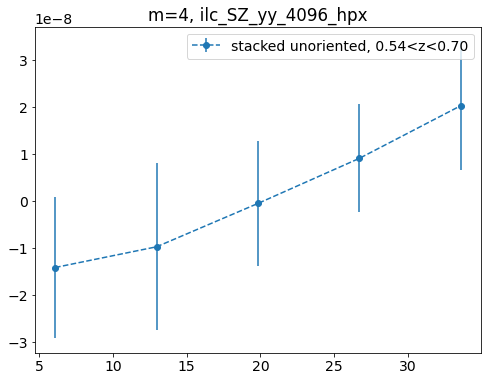

24 24


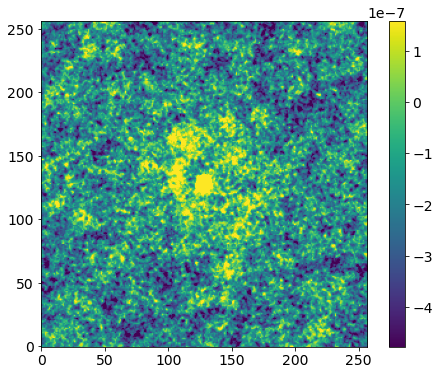

1279
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_yy_4096_hpx_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 5.41832713752859


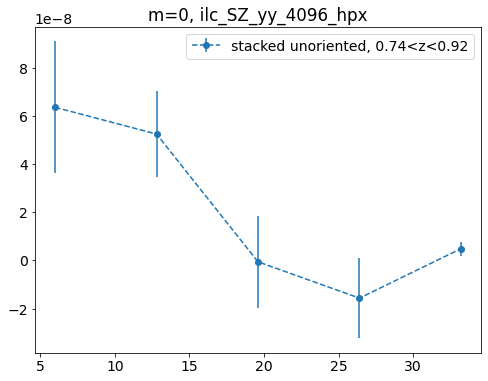

SNR 1.3935962287859238


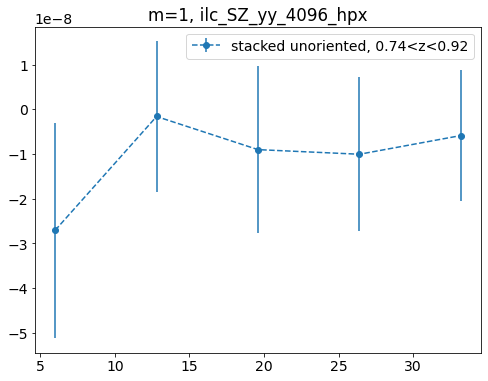

SNR 1.1315648994016672


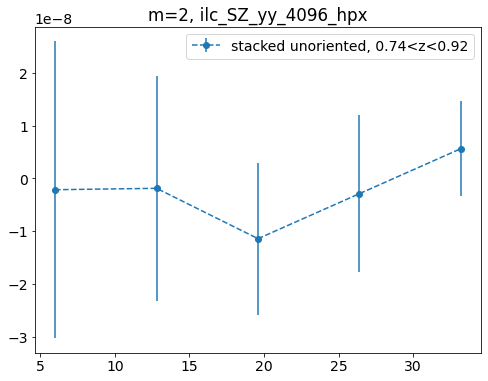

SNR 2.3133448944339072


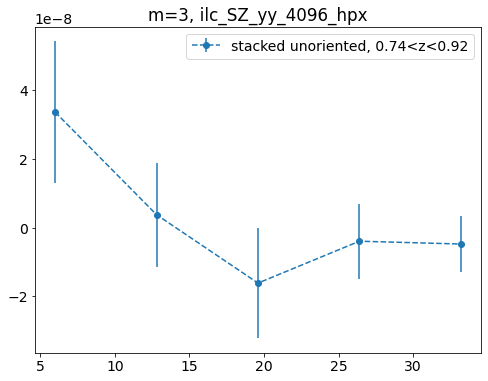

SNR 2.2656684062055916


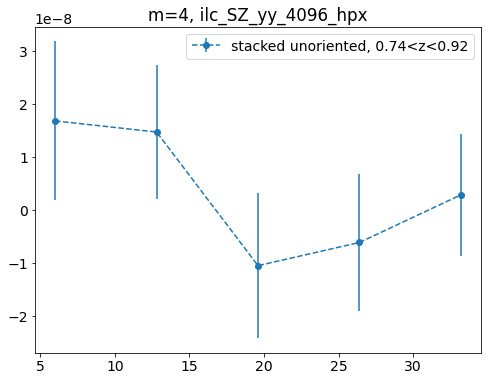

24 24


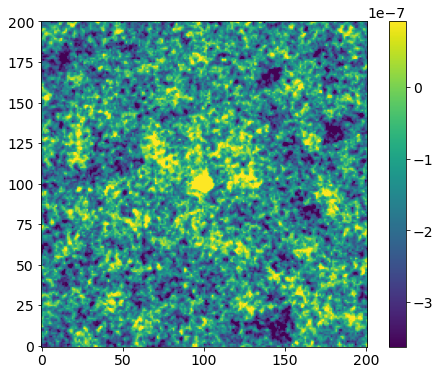

2070
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/kappa_bin4_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 13.519305269504999


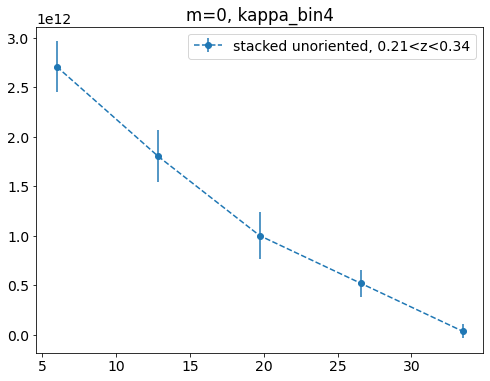

SNR 1.867618958732727


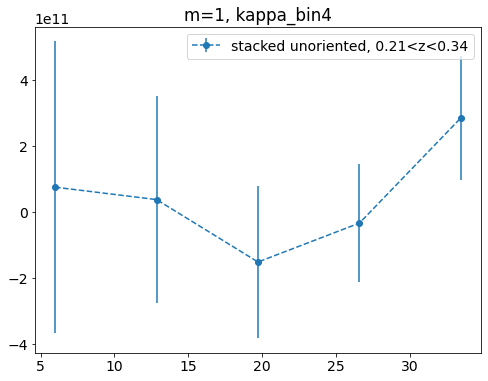

SNR 2.096865779812991


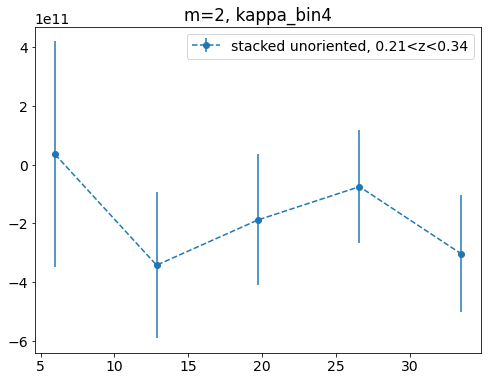

SNR 2.2895489292621196


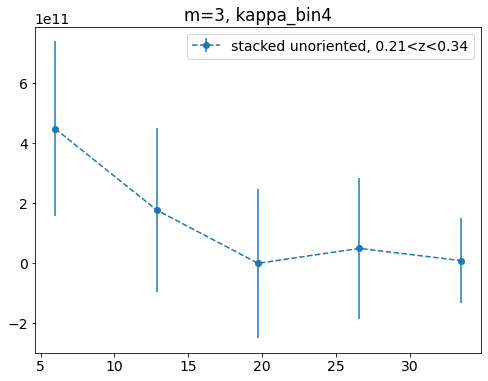

SNR 0.8615187497516866


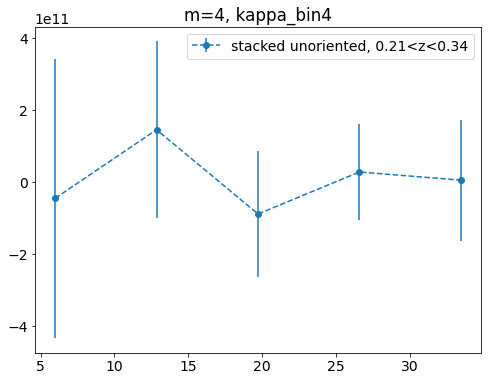

23 23


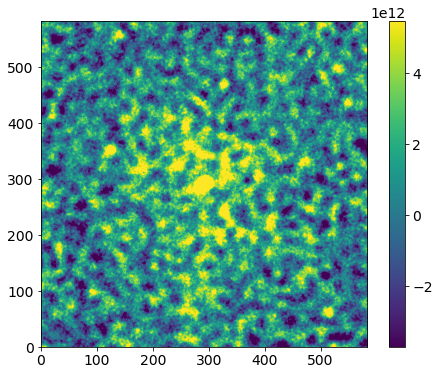

517
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/kappa_bin4_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 9.189151989689728


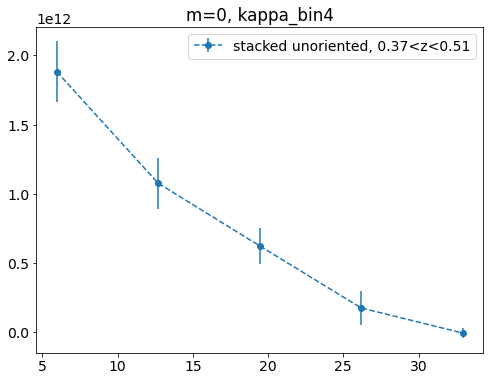

SNR 2.609049984810777


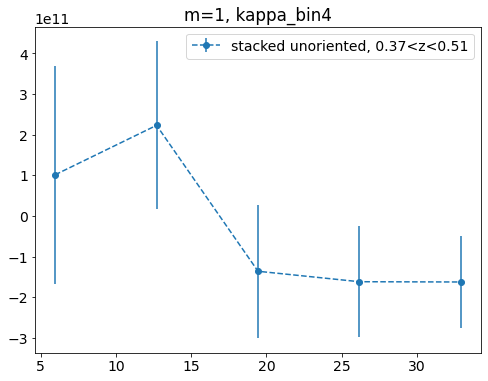

SNR 3.2094828448450863


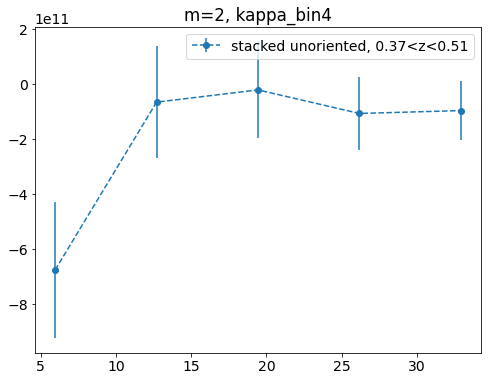

SNR 1.531678747601287


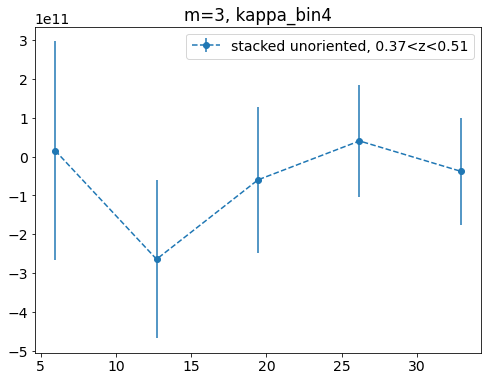

SNR 4.022062152310605


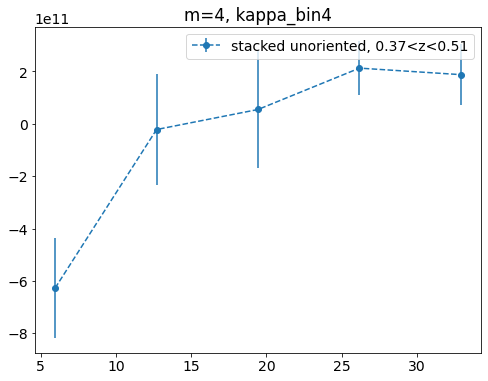

24 24


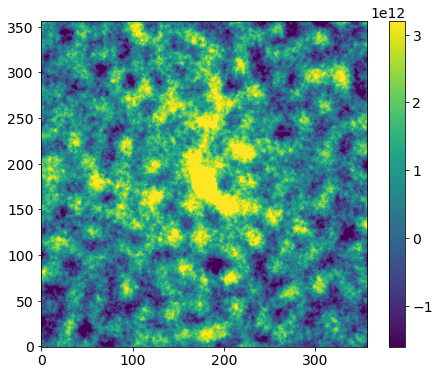

782
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/kappa_bin4_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 12.438090982174085


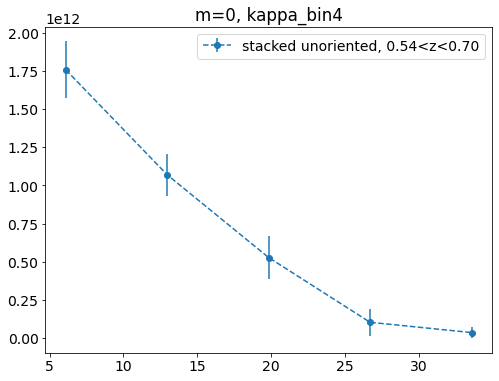

SNR 2.6330601362372814


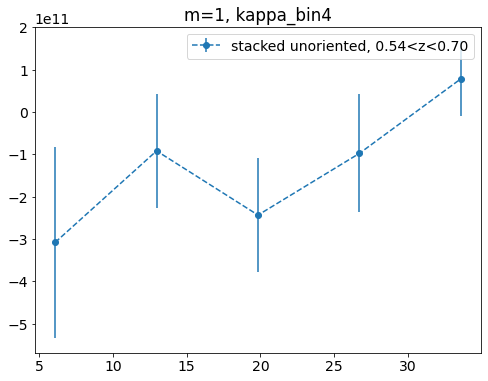

SNR 1.7367004086531843


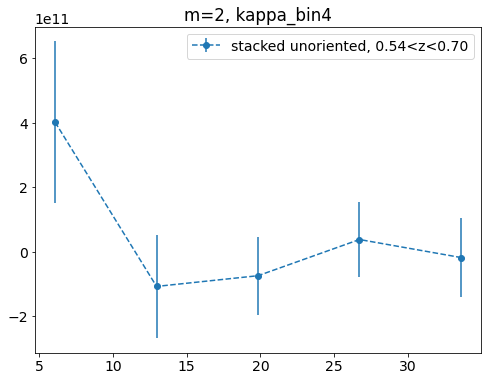

SNR 1.0801628584697052


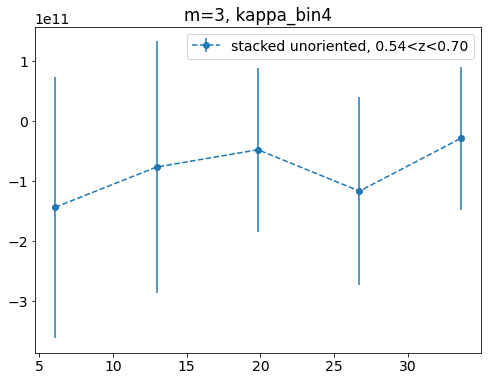

SNR 2.287295692504509


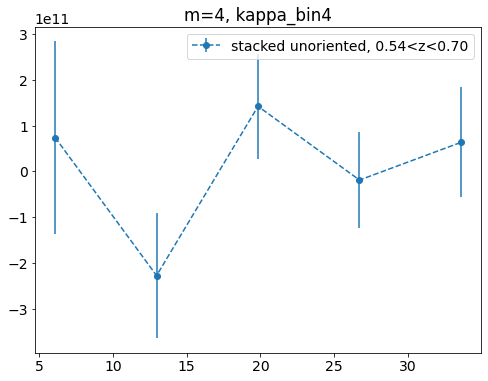

24 24


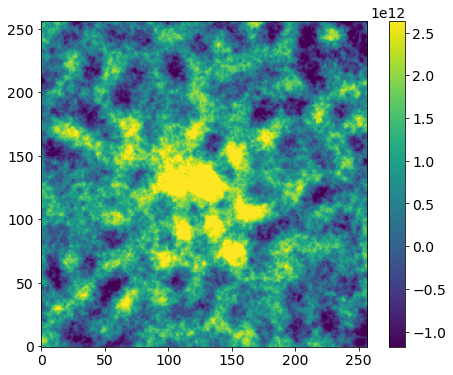

1279
retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/kappa_bin4_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_randrot_cc_24reg_m0to5_profiles.pkl
SNR 2.594101307861852


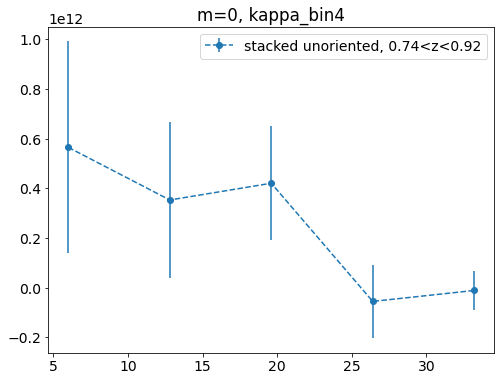

SNR 1.3495678050856168


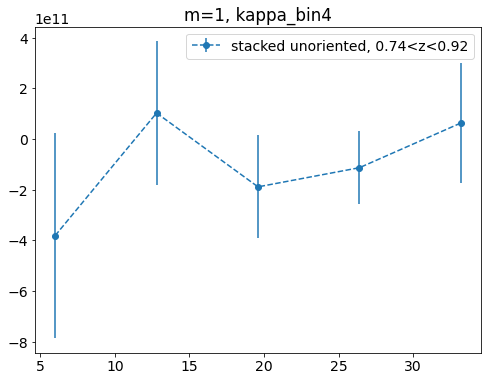

SNR 2.228199665346544


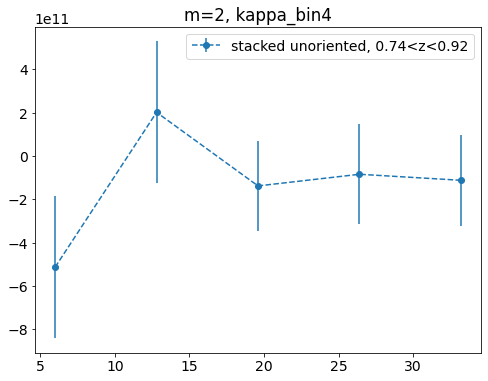

SNR 3.232983761168049


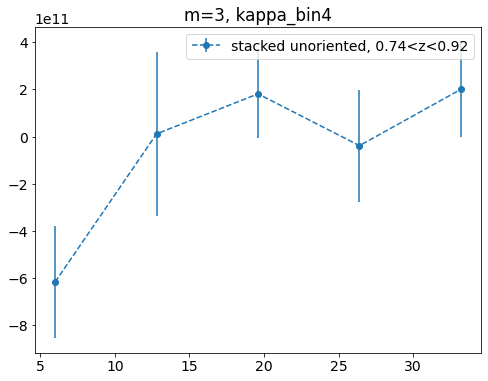

SNR 1.534176523109338


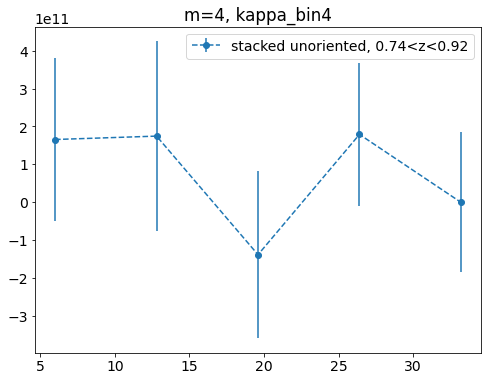

24 24


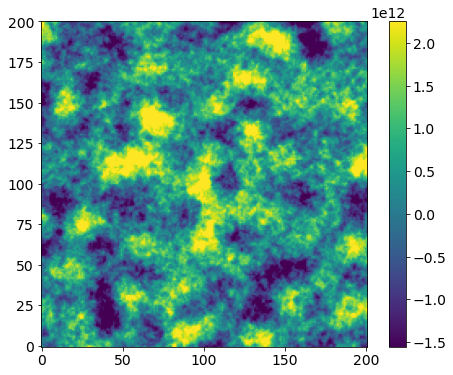

2070


<Figure size 576x432 with 0 Axes>

In [17]:
mapstr = f'DES_maglim_z_'
null_chi2_gal, null_pte_gal = get_chi2_pte_null(mapstr)
mapstr = 'ilc_SZ_yy_4096_hpx'
null_chi2_y, null_pte_ilc = get_chi2_pte_null(mapstr)
mapstr = 'kappa_bin4'
null_chi2_kappa, null_pte_kappa = get_chi2_pte_null(mapstr)


# Plot all the chi-square together to see if the distribution is consistent with zero

In [22]:
null_chi2_gal.shape

(5, 4)

Text(0.5, 0, '$\\chi^2$')

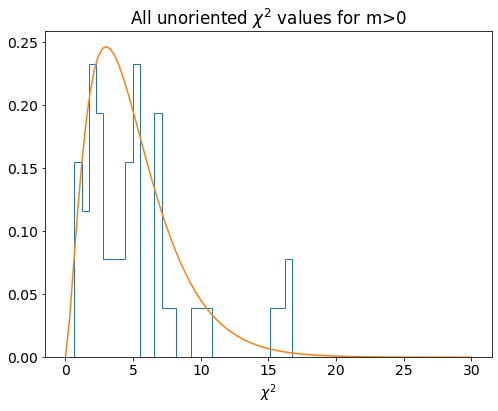

In [39]:
# Histogram all the chi-square for m>0 to see if the distribution is consistent with zero
all_chi2_null = (np.concatenate((null_chi2_gal[1:], null_chi2_y[1:], null_chi2_kappa[1:]))).flatten()
plt.hist(all_chi2_null, bins=30, histtype='step', label='all chi2 null', density=True)
# overplot a chi2 distribution with 5 dof
x = np.linspace(0, 30, 100)
plt.plot(x, stats.chi2.pdf(x, 5)*len(all_chi2_null)/30, label='chi2 pdf, 5 dof')
plt.title(r"All unoriented $\chi^2$ values for m>0")
plt.xlabel(r"$\chi^2$")


Text(0.5, 0, 'PTE')

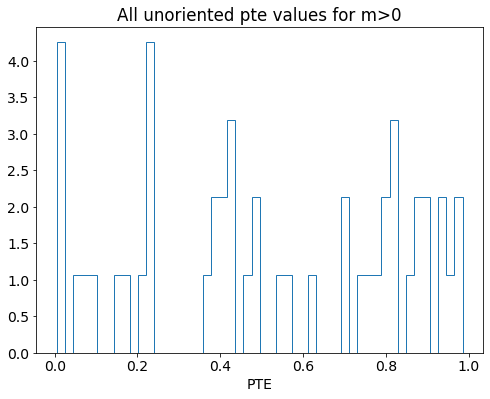

In [52]:
# histogram all the pte values
all_pte_null = (np.concatenate((null_pte_gal[1:], null_pte_ilc[1:], null_pte_kappa[1:]))).flatten()
plt.hist(all_pte_null, bins=50, histtype='step', label='all pte null', density=True)
plt.title(r"All unoriented pte values for m>0")
plt.xlabel("PTE")

In [ ]:
# null_snr = np.zeros((5,len(dbins)))
null_chi2 = np.zeros((5,len(dbins)))
null_pte = np.zeros((5,len(dbins)))
for c, cl_dbin in enumerate(dbins):
    cl_dlow, cl_dhi = cl_dbin[0], cl_dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    mapstr = 'ilc_SZ_yy_4096_hpx'
    
    randrotfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_randrot_cc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, nreg)
    unoriented, (zlow,zhi)   = cpp.retrieve_stack_info(None, None, None, cl_dbin, fullfile=randrotfile, remove_r30=True)
    mlen = len(unoriented.avg_profiles)
    for m in range(mlen):
        null_vector = np.zeros(len(unoriented.avg_profiles_binned[m]))
        chi2 = chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])
        # print("Chi-squared of unoriented stack w.r.t. zero", st.chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])/(len(unoriented.avg_profiles[m])-1))
        # pte, snr = st.snr_from_pte(unoriented.avg_profiles_binned[m][1:], null_vector[1:], unoriented.covmat_binned[m][1:,1:], chisq_data=None)
        null_chi2[m,c] = chi2
        dof = len(unoriented.avg_profiles_binned[m])
        pval = stats.chi2.sf(chi2, dof)
        null_pte[m,c] = pval
        print("SNR", np.sqrt(chi2))
        plt.errorbar(unoriented.r_binned, unoriented.avg_profiles_binned[m], yerr=unoriented.errors_binned[m], fmt='o', linestyle='--', label='stacked unoriented, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
        plt.legend()
        plt.title("m={:d}".format(m))
        plt.show()
        plt.clf()
        
    print(len(unoriented.img_splits), unoriented.Nsamples)
    plt.imshow(unoriented.avg_img, origin='lower', vmin=np.mean(unoriented.avg_img)-2*np.std(unoriented.avg_img), vmax=np.mean(unoriented.avg_img)+2*np.std(unoriented.avg_img))
    plt.colorbar()
    plt.show()
    plt.clf()
    
    print(np.sum(unoriented.Npks_splits))
    # profs_dbin.append(unoriented.avg_profiles_binned[m])
    # errors_dbin.append(errs.errors_binned[m])

In [40]:
# check whether the PTE distribution is consistent with uniform via the KS test
from scipy.stats import kstest

ks, pval = kstest(null_pte[1:].flatten(), 'uniform')
if pval < 0.05:
    same=False
    print(f'p-val is {pval}, so not the same distribution buddy')
else:
    same=True
    print(f'p-val is {pval}, so these are from the same distribution')



p-val is 0.9528558032914413, so these are from the same distribution


1.3691114009330027e-37 0.9805717642419918


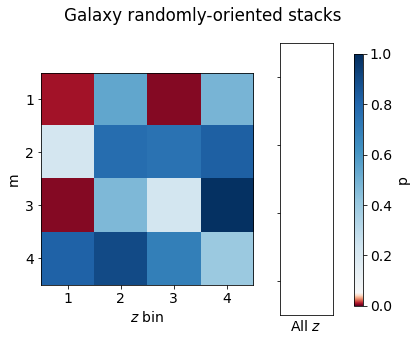

In [45]:
# pte version
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
pte_plot = ax[0].imshow(null_pte_gal[1:], cmap=scmap, vmin=0, vmax=1)
ax[0].set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
ax[0].set_yticks(np.arange(4))
ax[0].set_yticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
# ax[1].imshow(null_pte_full[1:], cmap=scmap, vmin=0, vmax=1)
# print(np.amin(null_pte_full[1:]), np.amax(null_pte_full[1:]))
print(np.amin(null_pte), np.amax(null_pte))
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pte_plot, cax=cbar_ax, label="p")
plt.suptitle("Galaxy randomly-oriented stacks")
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_randoriented_nulltest.pdf".format(mapstr), bbox_inches="tight")
plt.show()


NameError: name 'null_pte_full' is not defined

1.3691114009330027e-37 0.9805717642419918


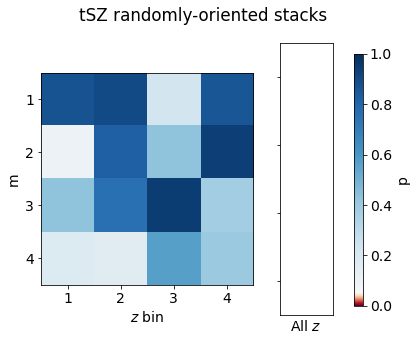

In [47]:
# pte version
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
pte_plot = ax[0].imshow(null_pte_ilc[1:], cmap=scmap, vmin=0, vmax=1)
ax[0].set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
ax[0].set_yticks(np.arange(4))
ax[0].set_yticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
# ax[1].imshow(null_pte_full[1:], cmap=scmap, vmin=0, vmax=1)
# print(np.amin(null_pte_full[1:]), np.amax(null_pte_full[1:]))
print(np.amin(null_pte), np.amax(null_pte))
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pte_plot, cax=cbar_ax, label="p")
plt.suptitle("tSZ randomly-oriented stacks")
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_randoriented_nulltest.pdf".format(mapstr), bbox_inches="tight")
plt.show()


1.3691114009330027e-37 0.9805717642419918


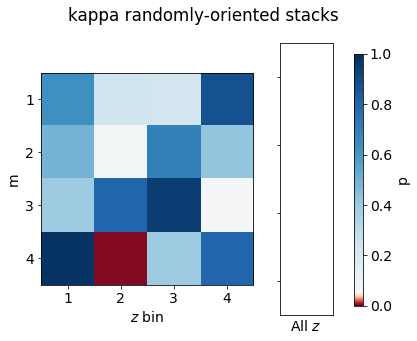

In [49]:
# pte version
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
pte_plot = ax[0].imshow(null_pte_kappa[1:], cmap=scmap, vmin=0, vmax=1)
ax[0].set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
ax[0].set_yticks(np.arange(4))
ax[0].set_yticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
# ax[1].imshow(null_pte_full[1:], cmap=scmap, vmin=0, vmax=1)
# print(np.amin(null_pte_full[1:]), np.amax(null_pte_full[1:]))
print(np.amin(null_pte), np.amax(null_pte))
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pte_plot, cax=cbar_ax, label="p")
plt.suptitle("kappa randomly-oriented stacks")
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_randoriented_nulltest.pdf".format(mapstr), bbox_inches="tight")
plt.show()


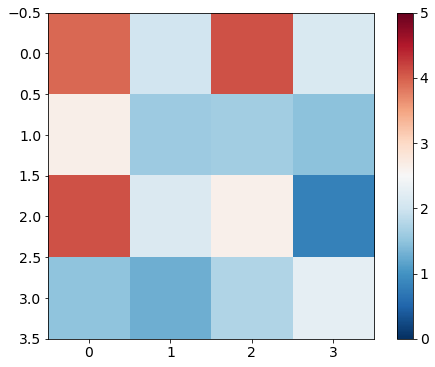

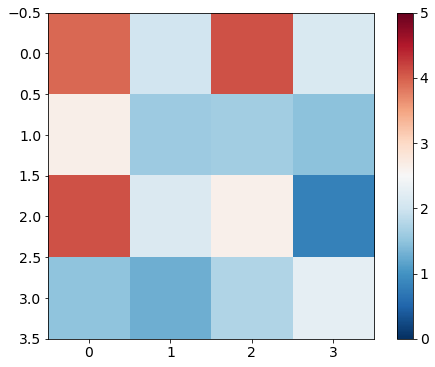

<Figure size 576x432 with 0 Axes>

In [77]:
null_snr = np.sqrt(stats.chi2.ppf(1 - null_pte, 5))
plt.imshow(null_snr[1:], cmap='RdBu_r', vmin=0, vmax=5)
plt.colorbar()
plt.show()
plt.clf()

null_snr2 = np.sqrt(null_chi2)
plt.imshow(null_snr2[1:], cmap='RdBu_r', vmin=0, vmax=5)
plt.colorbar()
plt.show()
plt.clf()


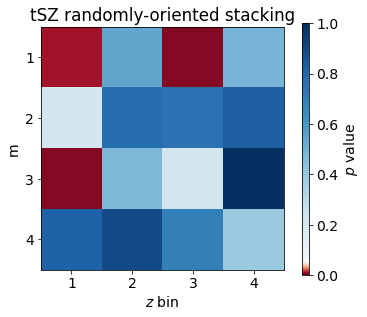

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
# snr_plot = ax.imshow(null_snr[1:], cmap='RdBu_r', vmin=0, vmax=4)
pte_plot = ax.imshow(null_pte[1:], cmap=scmap, vmin=0, vmax=1)
ax.set_ylabel("m")
# label y ticks with m values
ax.set_yticks(np.arange(len(null_pte[1:])))
ax.set_yticklabels(["1", "2", "3", "4"])
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax.set_xticks(np.arange(len(dbins)))
ax.set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax.set_xlabel(r"$z$ bin")
plt.title("tSZ randomly-oriented stacking")
# add an axis for a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pte_plot, cax=cbar_ax, label=r"$p$ value")

# centered title
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_randoriented_nulltest.pdf".format(mapstr), bbox_inches="tight")
plt.show()

In [24]:
# save for later
# kappa_ptes = null_pte
# y_ptes = null_pte
gal_ptes = null_pte

(array([17.,  2.,  3.,  2.,  7.,  3.,  2.,  2.,  1.,  2.,  1.,  3.,  0.,
         2.,  2.,  0.,  3.,  3.,  2.,  3.]),
 array([9.75759239e-160, 4.85520707e-002, 9.71041413e-002, 1.45656212e-001,
        1.94208283e-001, 2.42760353e-001, 2.91312424e-001, 3.39864495e-001,
        3.88416565e-001, 4.36968636e-001, 4.85520707e-001, 5.34072777e-001,
        5.82624848e-001, 6.31176918e-001, 6.79728989e-001, 7.28281060e-001,
        7.76833130e-001, 8.25385201e-001, 8.73937272e-001, 9.22489342e-001,
        9.71041413e-001]),
 <BarContainer object of 20 artists>)

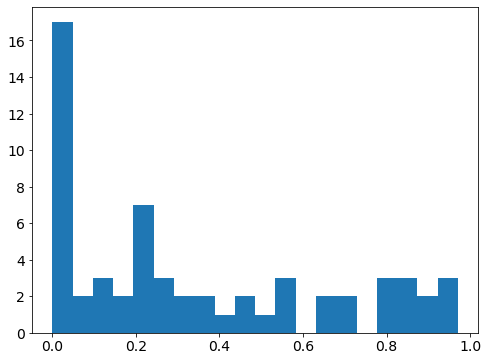

In [26]:
# plot all the PTEs to see if uniform
plt.hist(np.concatenate((kappa_ptes.flatten(), y_ptes.flatten(), gal_ptes.flatten())), bins=20)


(75.0, 125.0)

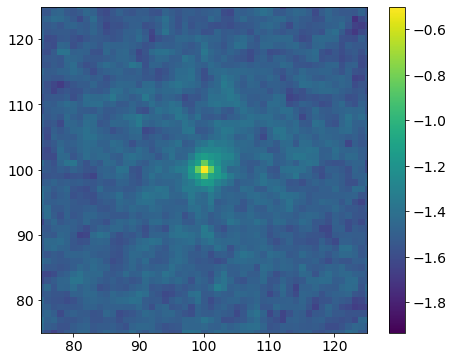

In [12]:
# plt.imshow(unoriented.avg_img, origin='lower', vmin=np.mean(unoriented.avg_img)-8*np.std(unoriented.avg_img), vmax=np.mean(unoriented.avg_img)+8*np.std(unoriented.avg_img))
plt.imshow(np.log10(unoriented.avg_img), origin='lower', vmax=-.5)
plt.colorbar()
# zoom in on the center
plt.xlim(75,125)
plt.ylim(75,125)

In [13]:
profs_dbin = []
errors_dbin = []
zlow = z_at_value(cosmo.comoving_distance, 893*u.Mpc)
zhi = z_at_value(cosmo.comoving_distance, 3193*u.Mpc)
null_snr_tot = np.zeros((5,1))
null_pte_tot = np.zeros((5,1))
randrotfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_893_3193Mpc_{:s}20pt0_randrot_{:d}reg_m0to5_profiles.pkl".format(mapstr, pt_selection_str, nreg)
unoriented = cpp.retrieve_stack_info(None, None, None, [893, 3193], fullfile=randrotfile, remove_r30=True)
mlen = unoriented.profile_splits.shape[0]

for m in range(mlen):
    null_vector = np.zeros(len(unoriented.avg_profiles_binned[m]))
    # print("Chi-squared of mask stack w.r.t. zero", st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])/(len(mask.avg_profiles[m])-1))
    pte, snr = st.snr_from_pte(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m], chisq_data=None)
    null_snr_tot[m,0] = snr
    null_pte_tot[m,0] = pte

    plt.errorbar(unoriented.r_binned, unoriented.avg_profiles_binned[m], yerr=unoriented.errors_binned[m], fmt='o', linestyle='--', label='stacked mask, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.title("m={:d}".format(m))
    plt.show()
    plt.clf()
    
    

plt.imshow(unoriented.avg_img, origin='lower')
plt.colorbar()
plt.show()
plt.clf()

# print(mask.Npks_splits)
# profs_dbin.append(mask.avg_profiles_binned[m])
# errors_dbin.append(mask.errors_binned[m])



retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/kappa_bin4_redmapper_lambdagt20_combined_893_3193Mpc_nugt2_egtpt3_20pt0_randrot_24reg_m0to5_profiles.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/kappa_bin4_redmapper_lambdagt20_combined_893_3193Mpc_nugt2_egtpt3_20pt0_randrot_24reg_m0to5_profiles.pkl'

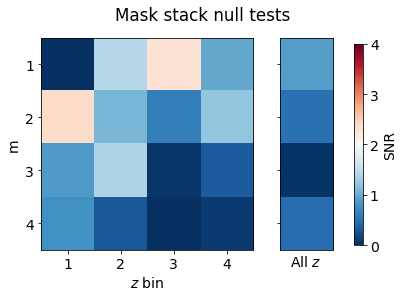

In [18]:
# set up figure with shared y and ratio 4 to 1
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
# scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax[0].imshow(null_snr[1:], cmap='RdBu_r', vmin=0, vmax=4)
ax[0].set_ylabel("m")
ax[0].set_yticks(np.arange(len(null_snr[1:])))
ax[0].set_yticklabels(["1", "2", "3", "4"])
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
ax[1].imshow(null_snr_tot[1:], cmap='RdBu_r', vmin=0, vmax=4)
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
plt.suptitle("Mask stack null tests")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_snr_test_unoriented_allz.pdf".format(mapstr), bbox_inches="tight")
plt.show()
